In [1]:
#!git clone https://github.com/hukenovs/hagrid

In [2]:
#!pip install -r hagrid/requirements.txt 

### Imports

In [3]:
import pandas as pd
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
from tensorflow import keras
from sklearn.model_selection import train_test_split
import pytorch2keras
from PIL import Image
from keras_preprocessing.image import img_to_array
import os
# load_img
from keras.utils import load_img

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [4]:
# https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/

### Data Preprocessing

In [5]:
base_dir = os.path.join(os.getcwd(), '../Data')

In [6]:
train_ds = image_dataset_from_directory(base_dir, 
                                        validation_split=0.3,
                                        subset="training",
                                        seed=42,
                                        image_size=(200, 200),
                                        batch_size=32)

val_ds = image_dataset_from_directory(base_dir,
                                        validation_split=0.2,
                                        subset="validation",
                                        seed=42,
                                        image_size=(200, 200),
                                        batch_size=32)
test_ds = image_dataset_from_directory(base_dir,
                                        validation_split=0.1,
                                        subset="validation",
                                        seed=42,
                                        image_size=(200, 200),
                                        batch_size=32)

Found 870 files belonging to 29 classes.
Using 609 files for training.
Found 870 files belonging to 29 classes.
Using 174 files for validation.
Found 870 files belonging to 29 classes.
Using 87 files for validation.


#### Data augmentation

In [7]:
data_aug = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(200, 200, 3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.2),
    keras.layers.experimental.preprocessing.RandomZoom((-0.2, 0.2), (0.2, 0.2)),
    keras.layers.experimental.preprocessing.RandomContrast(0.2),
    keras.layers.experimental.preprocessing.RandomTranslation((-0.2, 0.2), (-0.2, 0.2))
])

### View sample images

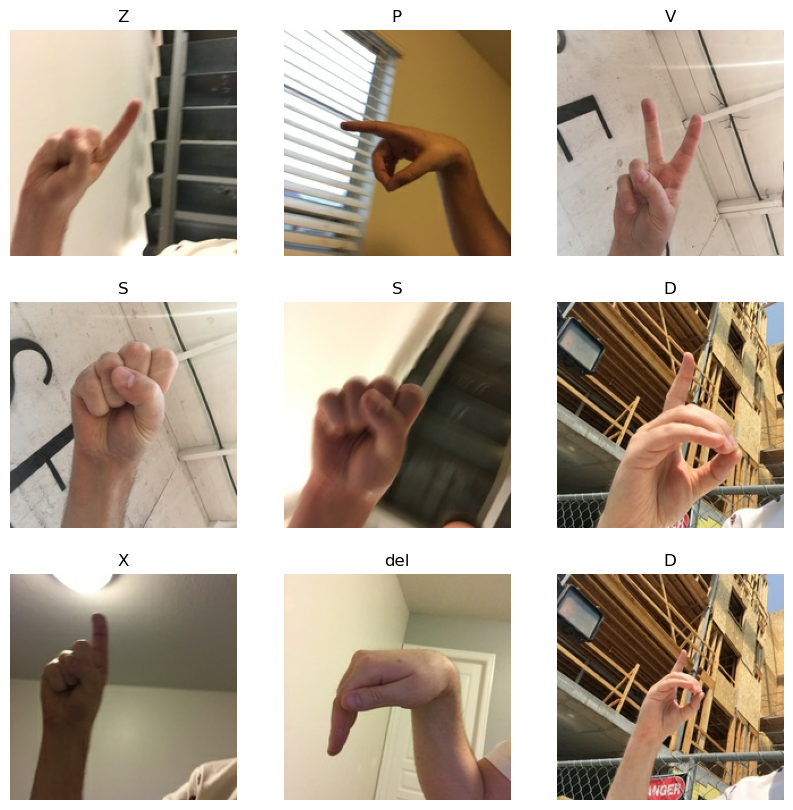

In [8]:
import matplotlib.pyplot as plt

classes = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[labels[i]])
        plt.axis("off")

### Apply Preprocessing

In [9]:
train = train_ds.map(lambda x, y: (data_aug(x, training=True), y))
#val = val_ds.map(lambda x, y: (data_aug(x, training=True), y))
#test = test_ds.map(lambda x, y: (data_aug(x, training=True), y))

AUTOTUNE = tf.data.AUTOTUNE
train = train.prefetch(buffer_size=AUTOTUNE)
val = val_ds.prefetch(buffer_size=AUTOTUNE)
test = test_ds.prefetch(buffer_size=AUTOTUNE)

In [10]:
# use preprocess_input to normalize the data
train = train.map(lambda x, y: (preprocess_input(x), y))
val = val.map(lambda x, y: (preprocess_input(x), y))
test = test.map(lambda x, y: (preprocess_input(x), y))

In [11]:
base_model = VGG16(include_top=False, input_shape=(200, 200, 3), weights='imagenet')
image_batch, label_batch = next(iter(train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 512)


In [12]:
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [13]:
num_classes = len(classes)
predction_layer = keras.layers.Dense(num_classes, activation='softmax')

In [14]:
inputs = keras.Input(shape=(200, 200, 3))
x = base_model(inputs, training=False)
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.2)(x)
#x = keras.layers.Dense(128, activation='relu')(x)
outputs = predction_layer(x)
model = keras.Model(inputs, outputs)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dropout (Dropout)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 29)                534557    
                                                                 
Total params: 15,249,245
Trainable params: 534,557
Non-trainable params: 14,714,688
_________________________________________________________________


In [16]:
# compile model
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# train
epoch = 25
history = model.fit(train, epochs=epoch, validation_data=val)

Epoch 1/25
20/20 [==============================] - 40s 2s/step - loss: 18.3538 - accuracy: 0.1051 - val_loss: 15.1664 - val_accuracy: 0.2356
Epoch 2/25
20/20 [==============================] - 40s 2s/step - loss: 13.5983 - accuracy: 0.3251 - val_loss: 10.8434 - val_accuracy: 0.3736
Epoch 3/25
20/20 [==============================] - 41s 2s/step - loss: 10.3792 - accuracy: 0.4089 - val_loss: 12.8927 - val_accuracy: 0.4483
Epoch 4/25
20/20 [==============================] - 40s 2s/step - loss: 9.4432 - accuracy: 0.4729 - val_loss: 10.0939 - val_accuracy: 0.4770
Epoch 5/25
20/20 [==============================] - 41s 2s/step - loss: 7.9680 - accuracy: 0.5353 - val_loss: 10.4495 - val_accuracy: 0.5000
Epoch 6/25
20/20 [==============================] - 42s 2s/step - loss: 9.6144 - accuracy: 0.5517 - val_loss: 7.8806 - val_accuracy: 0.5805
Epoch 7/25
20/20 [==============================] - 40s 2s/step - loss: 8.0888 - accuracy: 0.5846 - val_loss: 10.7041 - val_accuracy: 0.5230
Epoch 8/25


In [17]:
# evaluate test set
test_loss, test_acc = model.evaluate(test)

3/3 [==============================] - 4s 1s/step - loss: 10.3017 - accuracy: 0.6782


### Visualize results

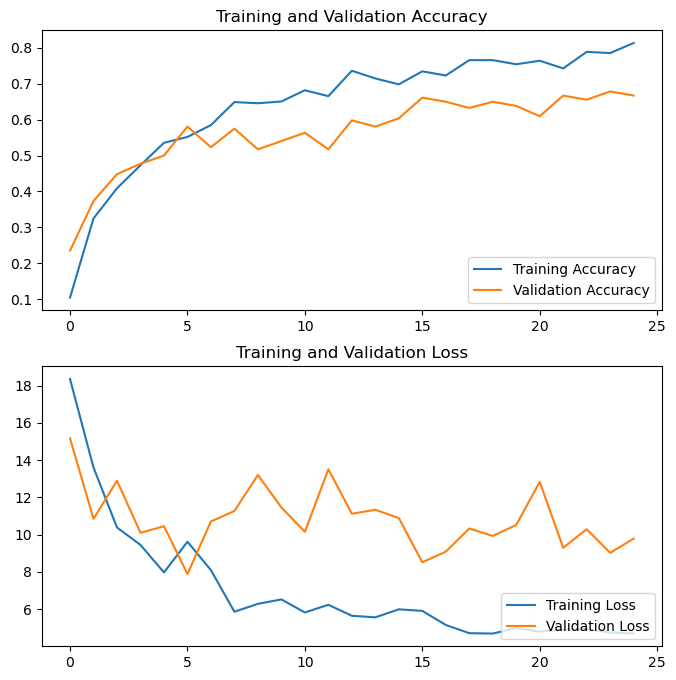

In [18]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epoch)
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 2s 2s/step


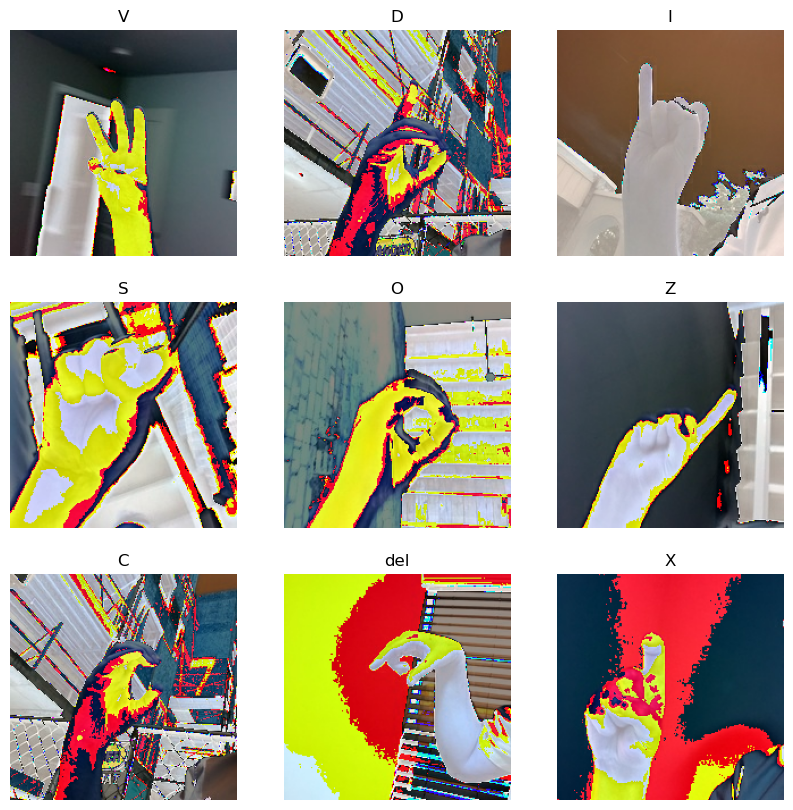

In [19]:
image_batch, label_batch = next(iter(test))
predictions = model.predict(image_batch)

predictions = np.argmax(predictions, axis=1)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(classes[predictions[i]])
    plt.axis("off")

1/1 [==============================] - 1s 1s/step


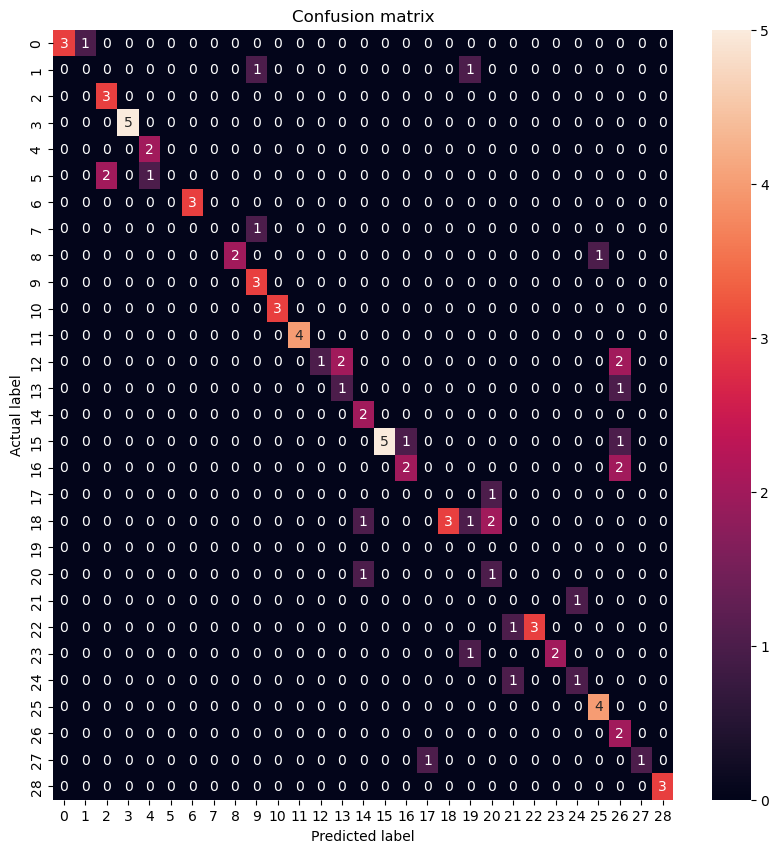

In [20]:
confusion_matrix_actual = []
confusion_matrix_predicted = []

for images, labels in test:
    predictions = model.predict(images)
    predictions = np.argmax(predictions, axis=1)
    confusion_matrix_actual.extend(labels)
    confusion_matrix_predicted.extend(predictions)

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(confusion_matrix_actual, confusion_matrix_predicted)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()